# Apply Topological Sort to Directed Acyclic Graphs

A directed acyclic graph (DAG) is a special type of directed network. As the name suggests, it is an acyclic network — a network that does not contain any cycles. Visually, a DAG is a tree, a forest, a star, or a linear graph.

Directed acyclic graphs describe hierarchies — systems in which their components are ranked one above the other according to some property. (A hierarchy is often informally referred to as a “pecking order”: who pecks whom?) In a hierarchy, any two components **A** and **B** are either unrelated, or **A** is unambiguously subordinated to **B**, or **B** is unambiguously subordinated to **A**, either directly or indirectly. On the contrary, subordination is ambiguous in directed graphs with cycles. For example, in a two-node ring consisting only of **A** and **B**, both nodes can claim that they supervise the other node.

All **NetworkX** functions and techniques for directed networks naturally work for DAGs, but several functions are intended solely for DAGs. Function **nx.is_directed_acyclic_graph(G)** checks if **G** is a DAG or not. Function **nx.transitive_closure(G)** calculates a transitive closure **T** of **G**: a graph that has the same nodes as **G** such that two nodes in **T** are adjacent if and only if there is a path between the two nodes in **G**. Think of a transitive closure as a graph of all possible subordination relationships, both direct and indirect.

You can serialize a DAG and arrange all nodes in a linear order, so that the next node may be a subordinate of the previous node, but the previous node is never a subordinate of the next node. The result of the serialization is a ranking of all nodes, with the source nodes at the beginning and target nodes at the end. This operation is called topological sort. You can sort a DAG in many different ways, resulting in different “pecking” rankings. Function **nx.topological_sort(G)** returns one randomly chosen ranking as a list of node labels.

## Use DAG topological sort to produce a list of qualitative adjectives

Directed network analysis has an unexpected connection to creative writing and computer game development.

Game developers and creative writers are often in need of a collection of adjectives that characterize a particular property and range from “very bad” to “very good.” Directed network analysis (via the module **toposort**) makes it possible to design such a scale in any natural language.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import toposort
from networkx.drawing.nx_agraph import graphviz_layout
import dzcnapy_plotlib as dzcnapy

### Obtain and Extract Survey Data

You can start this mini case study by defining a list of candidate adjectives; in our case, the list consists of thirty-four words: “alpha plus,” “average,” “bad,” “crappy,” “disgusting,” “excellent,” “exciting,” “f*cking good,” “fantastic,” “filthy,” “first-class,” “good,” “great,” “horrible,” “lousy,” “magical,” “mediocre,” “pathetic,” “nice,” “none of a,” “normal,” “not bad,” “phenomenal,” “premium,” “repugnant,” “shitty,” “so-so,” “solid,” “strong,” “superb,” “superior,” “unfit,” “weak,” and “worthless.

Post the list as a survey to Qualtrics, SurveyMonkey, or your other favorite survey-taking site. You have to design the questionnaire in such a way that the takers either rank all words in the order from the “best” to the “worst” or assign a numerical measure of “goodness” to each word. The survey design is outside the scope of this book, but keep in mind that asking survey takers to arrange thirty-four words on a cellphone screen may be more than an average person is ready to commit to.

Once you collect enough samples, download the results as a CSV file (**Adjectives_by_the_rank.csv** is provided with this notebook, you do not need to create it for now). Depending on the surveying site, the file may need a lot of cleanup before becoming useful. The following code fragment imports a CSV file produced by Qualtrics, extracts the thirty-four columns that correspond to the word ranks, and removes the survey question from the column names.

In [2]:
ranks = pd.read_csv("Adjectives_by_the_rank.csv",
                    header=1).set_index("ResponseID").fillna(0)
Q1 = "Rank the words from the most positive to the most negative-"
ranks = ranks.loc[:, ranks.columns.str.startswith(Q1)].astype(int)
ranks.columns = ranks.columns.str.replace(Q1, "")

Let’s now build a network of words. Each column of the **DataFrame ranks** represents the ranks of a word from each participant. Connect the word **i** to another word **j** with a directed edge if the participants agree, to some extent, that **i** is “better” than **j**. The definition of what constitutes the agreement may be stringent (by consensus), weak (when at least two participants agree), or somewhere in the middle (say, at least 115 of 158 participants agree). The consensus-based network would have very few, if any, edges. The network based on the weak criterion may have too many edges and contain cycles. We want to construct a network that is dense but still has no cycles, because if it is not a DAG, then it cannot be topologically sorted.

In [3]:
dominance = pd.DataFrame([[(ranks[j] > ranks[i]).sum()
                           for i in ranks] for j in ranks],
                         columns=ranks.columns, index=ranks.columns)


In [4]:
QUORUM = 115
edges = sorted(dominance[dominance >= QUORUM].stack().index.tolist())
G = nx.DiGraph(edges)

### Execute Topological Sort

You can try to bring some order by topologically sorting the network.

The output of the function is unbelievably realistic. “Fantastic” is undeniably better than “great,” which is better than “lousy,” which is better than “disgusting.” The only problem with the function **nx.topological_sort(G)** is that it returns only one possible topological sort order. It forcefully ranks the nodes that are otherwise topologically equivalent, adding unnecessary constraints to the way the node labels can be used. There is no way to obtain another order with **nx.topological_sort.**.

In [5]:
# Sort in the reverse order
print(list(nx.topological_sort(G))[::-1])

['exciting', 'fantastic', 'phenomenal', 'magical', 'alpha plus', 'excellent', 'great', 'f*cking good', 'first-class', 'superb', 'superior', 'premium', 'good', 'solid', 'strong', 'nice', 'normal', 'not bad', 'average', 'mediocre', 'none of a', 'so-so', 'weak', 'bad', 'unfit', 'lousy', 'pathetic', 'worthless', 'crappy', 'filthy', 'horrible', 'shitty', 'disgusting', 'repugnant']


The module **toposort** provides the function **toposort.toposort(edge_dict)** that does not have the limitations of the function **nx.topological_sort**. This function returns a generator of sets of topologically equivalent nodes. A node in a set does not dominate and is not dominated by any node in the same set. Game developers and creative writers, the prospective users of the word sets, would treat all words in one set as having the same sentiment (but not necessarily the same valence).

The function **toposort.toposort(edge_dict)** is not integrated with **NetworkX**. Before using the function, transform a NetworkX edge list **G.edges()** into a dictionary where nodes are keys, and sets of their neighbors are values.

In [6]:
edge_dict = {n1: set(ns) for n1, ns in nx.to_dict_of_lists(G).items()}
topo_order = list(toposort.toposort(edge_dict))
print(topo_order)

[{'exciting', 'phenomenal', 'fantastic'}, {'f*cking good', 'first-class', 'great', 'superior', 'superb', 'magical'}, {'excellent', 'premium', 'alpha plus'}, {'strong', 'good', 'solid'}, {'not bad', 'nice', 'normal'}, {'average'}, {'so-so', 'mediocre', 'none of a'}, {'weak'}, {'unfit', 'worthless', 'bad', 'pathetic'}, {'lousy'}, {'crappy', 'horrible', 'filthy', 'shitty'}, {'disgusting', 'repugnant'}]


The new output is “phenomenal,” “exciting,” and “fantastic.” It consists of twelve equivalence classes of word, each class being “worse” than the predecessor and “better” than the successor. Despite being based only on 158 responses, the result does not look unexpected. The toposort algorithm is even “smart” enough to put the unappetizing adjectives in the second set from the end together.

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Liberation Sans Narrow'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


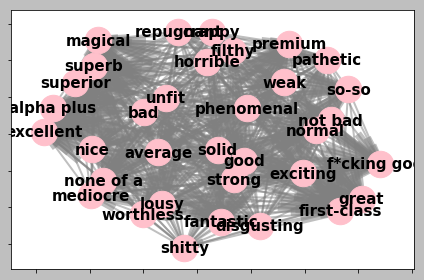

In [7]:
pos = graphviz_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.5, **dzcnapy.attrs)
nx.draw_networkx_nodes(G, pos, **dzcnapy.attrs)
nx.draw_networkx_labels(G, pos, **dzcnapy.attrs)

dzcnapy.set_extent(pos, plt)
dzcnapy.plot("adjectives")

## Your turn

Save the directed graph to a graphml 